# Data processing and analysis

## Preamble

In [407]:
%matplotlib inline
import boto3
from collections import defaultdict
from clio_lite import clio_search, clio_search_iter
import io
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
import numpy as np
import pandas as pd
import seaborn as sn
from matplotlib.lines import Line2D

In [337]:
# %load lda_pipeline.py
from gensim import corpora, models
from string import punctuation
from string import digits
import re
import pandas as pd
import numpy as np

#Characters to drop
drop_characters = re.sub('-','',punctuation)+digits

#Stopwords
from nltk.corpus import stopwords

stop = stopwords.words('English')

#Stem functions
from nltk.stem import *
stemmer = PorterStemmer()


def clean_tokenise(string,drop_characters=drop_characters,stopwords=stop):
    '''
    Takes a string and cleans (makes lowercase and removes stopwords)
    
    '''
    

    #Lowercase
    str_low = string.lower()
    
    
    #Remove symbols and numbers
    str_letters = re.sub('[{drop}]'.format(drop=drop_characters),'',str_low)
    
    
    #Remove stopwords
    clean = [x for x in str_letters.split(' ') if (x not in stop) & (x!='')]
    
    return(clean)


class CleanTokenize():
    '''
    This class takes a list of strings and returns a tokenised, clean list of token lists ready
    to be processed with the LdaPipeline
    
    It has a clean method to remove symbols and stopwords
    
    It has a bigram method to detect collocated words
    
    It has a stem method to stem words
    
    '''
    
    def __init__(self,corpus):
        '''
        Takes a corpus (list where each element is a string)
        '''
        
        #Store
        self.corpus = corpus
        
    def clean(self,drop=drop_characters,stopwords=stop):
        '''
        Removes strings and stopwords, 
        
        '''
        
        cleaned = [clean_tokenise(doc,drop_characters=drop,stopwords=stop) for doc in self.corpus]
        
        self.tokenised = cleaned
        return(self)
    
    def stem(self):
        '''
        Optional: stems words
        
        '''
        #Stems each word in each tokenised sentence
        stemmed = [[stemmer.stem(word) for word in sentence] for sentence in self.tokenised]
    
        self.tokenised = stemmed
        return(self)
        
    
    def bigram(self,threshold=10):
        '''
        Optional Create bigrams.
        
        '''
        
        #Colocation detector trained on the data
        phrases = models.Phrases(self.tokenised,threshold=threshold)
        
        bigram = models.phrases.Phraser(phrases)
        
        self.tokenised = bigram[self.tokenised]
        
        return(self)
        
        
        
        

class LdaPipeline():
    '''
    This class processes lists of keywords.
    How does it work?
    -It is initialised with a list where every element is a collection of keywords
    -It has a method to filter keywords removing those that appear less than a set number of times
    
    -It has a method to process the filtered df into an object that gensim can work with
    -It has a method to train the LDA model with the right parameters
    -It has a method to predict the topics in a corpus
    
    '''
    
    def __init__(self,corpus):
        '''
        Takes the list of terms
        '''
        
        #Store the corpus
        self.tokenised = corpus
        
    def filter_tokens(self,minimum=5):
        '''
        Removes keywords that appear less than 5 times.
        
        '''
        
        #Load
        tokenised = self.tokenised
        
        #Count tokens
        token_counts = pd.Series([x for el in tokenised for x in el]).value_counts()
        
        #Tokens to keep
        keep = token_counts.index[token_counts>minimum]
        
        #Filter
        tokenised_filtered = [[x for x in el if x in keep] for el in tokenised]
        
        #Store
        self.tokenised = tokenised_filtered
        self.empty_groups = np.sum([len(x)==0 for x in tokenised_filtered])
        
        return(self)
    
    def clean(self):
        '''
        Remove symbols and numbers
        
        '''
        
        
        
    
        
    def process(self):
        '''
        This creates the bag of words we use in the gensim analysis
        
        '''
        #Load the list of keywords
        tokenised = self.tokenised
        
        #Create the dictionary
        dictionary = corpora.Dictionary(tokenised)
        
        #Create the Bag of words. This converts keywords into ids
        corpus = [dictionary.doc2bow(x) for x in tokenised]
        
        self.corpus = corpus
        self.dictionary = dictionary
        return(self)
        
    def tfidf(self):
        '''
        This is optional: We extract the term-frequency inverse document frequency of the words in
        the corpus. The idea is to identify those keywords that are more salient in a document by normalising over
        their frequency in the whole corpus
        
        '''
        #Load the corpus
        corpus = self.corpus
        
        #Fit a TFIDF model on the data
        tfidf = models.TfidfModel(corpus)
        
        #Transform the corpus and save it
        self.corpus = tfidf[corpus]
        
        return(self)
    
    def fit_lda(self,num_topics=20,passes=5,iterations=75,random_state=1803):
        '''
        
        This fits the LDA model taking a set of keyword arguments.
        #Number of passes, iterations and random state for reproducibility. We will have to consider
        reproducibility eventually.
        
        '''
        
        #Load the corpus
        corpus = self.corpus
        
        #Train the LDA model with the parameters we supplied
        lda = models.LdaModel(corpus,id2word=self.dictionary,
                              num_topics=num_topics,passes=passes,iterations=iterations,random_state=random_state)
        
        #Save the outputs
        self.lda_model = lda
        self.lda_topics = lda.show_topics(num_topics=num_topics)
        

        return(self)
    
    def predict_topics(self):
        '''
        This predicts the topic mix for every observation in the corpus
        
        '''
        #Load the attributes we will be working with
        lda = self.lda_model
        corpus = self.corpus
        
        #Now we create a df
        predicted = lda[corpus]
        
        #Convert this into a dataframe
        predicted_df = pd.concat([pd.DataFrame({x[0]:x[1] for x in topics},
                                              index=[num]) for num,topics in enumerate(predicted)]).fillna(0)
        
        self.predicted_df = predicted_df
        
        return(self)
    

In [3]:
def flatten(a_list,freq=False):
    '''
    Flattens a nested list
    
    '''
    
    a_list_w_values = [x for x in a_list if x!=None]
    
    unnest = [x for el in a_list_w_values for x in el]
    
    if freq == False:
    
        return(unnest)
    
    else:
        return(pd.Series(unnest).value_counts())
        
    

In [310]:
def process_results(results,field_lookup,rel_rank=True,verbose=False):
    '''
    We process the results from a query
    
    Args:
        results (list) are the results of an emergent search query
        field_lookup (dict) is the lookup where the keys are the keys in the dict we want to keep, 
        and the values are the clean variable names
        rel_rank (bool) if we want to label articles with their position in the relevance decile
    
    '''
    
    if verbose != False:
        print(verbose)
    
    processed_df = pd.DataFrame([process_record(x,field_lookup) for x in results]).drop_duplicates(
        'record_id')
    
    if rel_rank==True:
        processed_df['query_relevance_rank']=pd.qcut(processed_df['relevance_score'],
                                                q=np.arange(0,1.1,0.1),labels=False,duplicates='drop')
    
    return(processed_df)
    
    

In [317]:
def process_record(record,field_lookup):
    '''
    
    Processes the records in a result from an emergent tech query.
    
    Args:
        results (list) are the results of an emergent search query
        field_lookup (dict) is the lookup where the keys are the keys in the dict we want to keep, 
        and the values are the clean variable names
    
    Returns:
        A dict with the relevant values
    
    '''
    

    
    out = {v:record[k] if k in record.keys() else np.nan for k,v in field_lookup.items()}
    
    return(out)

In [318]:
def check_field_freqs(df,q_var,top_fields,name):
    '''
    Some validation of results from ES queries.
    
    Args:
        df (df) is a dataframe with a relevance ranking
        q_var (str) is the relevance ranking variable
        top_fields (int) is the number of top fields we want to check
        title (str) is the name for the title 
    
    
    '''

    
    field_n = pd.concat([flatten(df.loc[
        df[q_var]==n]['fields_of_study'],freq=True) for n in np.arange(0,10,1)],
         axis=1).fillna(0) 
    
    top_fields = field_n.sum(axis=1).sort_values(ascending=False)[:30].index
    
    #Measure freqs of papers with top field of study
    field_freq = [[np.mean([f in all_fields if all_fields!=None else False for all_fields in df.loc[df[q_var]==n]['fields_of_study']]) for n in np.arange(
        0,10,1)] for f in top_fields]
    
    field_freq_df = pd.DataFrame(field_freq,index=top_fields,columns=np.arange(0,10,1))
    
    #Create plot
    fig,ax = plt.subplots(figsize=(20,10),ncols=2)
    
    sn.heatmap(field_n.apply(lambda x: x/x.sum()).loc[top_fields],cmap='viridis',ax=ax[0])
    
    ax[0].set_title(f'{name} Share of field in rank')
    
    sn.heatmap(field_freq_df,cmap='viridis',ax=ax[1])
    
    ax[1].set_yticklabels([])
    
    ax[1].set_title(f'{name} Share of papers with field in rank')
    
    plt.tight_layout()
    
    
    

In [864]:
# And remove papers with transnationals

def has_multinationals(list_institutions,multi_names):
    '''
    Looks for names of multinationals in institute lists:
    
    Args:
        list_institutions (list) a list of institutions involved in a paper
        multi_names (list) a list of multinationals we want to find
    
    Returns:
        True if any multi names in the institutes
    '''
    
    #has_multi = len(multi_names & set(flatten([x.lower().split(' ') for x in list_institutions])))>0
    
    has_multi = len(multi_names & set(list_institutions))>0
    
    return(has_multi)



In [205]:
def get_salience(df,topics,thres=0.75):
    '''
    Calculates the overrepresentation of a topic in a period
    
    Args:
        df (df) is a dataframe with topics by paper
        topics (list) are the columns with the topics
    
    '''
    
    agg = df.groupby('period')[topics].sum()
    
    lq = calculate_lq(agg)
    
    #Show high 
    for col in lq.columns:
        lq[f'high_{col}'] = [x>lq[col].quantile(thres) for x in lq[col]]
    
    return(lq)
    
    

In [206]:
def calculate_lq(df):
    '''
    Calculates the LQ
    
    '''
    
    den = df.apply(lambda x: x/x.sum(),axis=1)/(df.sum()/df.sum().sum())
    den = den.T
    
    den.index = [f'{x}_{topic_names[x]}' for x in den.index]
    
    
    return(den)
    

In [571]:
def national_report(df,meta_df,geo_var,geo_val,topic_rankings,topic_thres,levels):
    '''
    
    This function creates a national report of activity
    
    Arguments:
        df (df) is a dataframe where every record is a paper with a geovar and topics we query
        meta_df (df) is a dataframe with geographical metadata for the papers
        geo_var (str) is the variable with the geographical information
        geo_val (str) is the value - could be a country or a region
        topic_rankings (df) is the dataframe with the topic rankings we use to identigy activity in topics
        with different subjects
        topic_thres (int) is the value we use to threshold the data

    
    Returns a df with 
        #Total levels of activity in the data by year
        #Total levels of activity in topics in different categories ('modern topics' and 'traditional topics') by year
        #Shares of the total

    '''
    
    #Create a copy of the topic df
    df_c = df.copy()
    
    #Add the geo info to the topic df
    paper_topic_lookup = {x['record_id']:x[geo_var] for rid,x in meta_df.iterrows()}
    
    df_c[geo_var] = [paper_topic_lookup[x] for x in df_c.index]
    
    df_c[f'has_{geo_val}'] = [geo_val in geo for geo in df_c[geo_var]]
    
    #
    total_activity = geo_summary(df_c,geo_val,'all_ai')
    
    #Now focus on various topics
    topic_era = [[int(x.split('_')[0]) for x in topic_rankings.loc[topic_rankings[f'high_{n}']==True].index] for
                 n in levels]    
    
    df_sel = [df_c.loc[[any(x[t]>topic_thres for t in topic_set) for rid,x in df_c.iterrows()]]
                       for topic_set in topic_era]
    
    temp_activity= [geo_summary(my_df,geo_val,val) for my_df,val in zip(df_sel,['old','modern'])]
    
    
    return(pd.concat([total_activity,temp_activity[1],temp_activity[0]],axis=0))
    
    
    
    
    
    

In [572]:
def geo_summary(df,geo_val,name):
    '''
    
    Aggregates activity by location for different dfs (which eg capture different levels of activity in a topic) 
    
    '''
    
    year_comp = df.groupby(
        [f'has_{geo_val}','year']).size().reset_index(drop=False).pivot_table(index='year',
                                                                              columns=f'has_{geo_val}',
                                                                              values=0)
    
    year_comp.rename(columns={True:geo_val},inplace=True)
    
    year_comp['total'] = year_comp.sum(axis=1)
    
    year_comp.drop(False,axis=1,inplace=True)
    
    year_comp.reset_index(drop=False,inplace=True)
    
    year_long = year_comp.melt(id_vars='year',var_name='location')
    
    year_long['activity_type'] = name
    
    return(year_long)
    
    
    
    #year_comp[f'has_{geo_val}_share_{name}'] = 100*year_comp[True]/year_comp.sum(axis=1)
    
    #year_comp.rename(columns={True:f'has_{geo_val}_total_{name}'},inplace=True)
    
    #year_comp = year_comp.iloc[:,1:]
    #year_comp.columns = [x+f'_{name}' for x in year_comp.columns]
    
    #return(year_comp.drop(False,axis=1))
    
    
    

In [560]:
def make_disruption_tables(df,period):
    '''
    This function creates two datasets capturing inter-year changes in activity, which we consider a proxy for 'disruption'
    
    Arguments:
        df (df) is a dataframe with the topics
        period is the period we are interested in capturing
        
    Will return a df with inter-year distances
    
    '''
    
    #We want to measure distances between activity profiles in years

    #We create a vector with counts of papers with activity in a year
    year_topics_norm = df.groupby('year').sum().apply(lambda x: x/x.sum(),axis=1)
    
    year_sims = pd.DataFrame(1-pairwise_distances(year_topics_norm),
                             index=year_topics_norm.index,columns=year_topics_norm.index)
    
    return(year_sims)

def make_disruption_plot(disr_inputs,ax):
    '''
    This function creates a disruption plot
    
    Arguments:
        -a interyear distances
    
    '''
    #Get the period
    period = list(disr_inputs.columns)
    
    #This is to select the lower triangular matrix for the visualisation
    year_sims_2 =  pd.DataFrame(np.tril(disr_inputs, 
                                        k=0),index=period,columns=period).applymap(
        lambda x: np.nan if x==0 else x) #We make the zeroes nans to colour things later
    
    
    #Get the colourmap

    my_map = plt.cm.get_cmap('seismic')
    
    #Set missing values to white
    my_map.set_bad('white')


    #fig,ax = plt.subplots(figsize=(10,8),nrows=2,gridspec_kw={'height_ratios':[3,1.2]})
    
    #Create the heatmap
    im = ax.imshow(year_sims_2,cmap=my_map,aspect='auto')
    
    
    #Some formatting of labels etc
    #You always have to add the ticks and the ticklabels when doing imshow
    ax.set_xticks(np.arange(0,len(period)))
    ax.set_xticklabels(period)
    ax.set_yticks(np.arange(0,len(period)))
    ax.set_yticklabels(period)
    

    ax.set_title('Year on year topic similarity',size=14)

    #We remove the top and right-and lines of the frame
    ax.spines['top'].set_edgecolor('white')
    ax.spines['right'].set_edgecolor('white')
    ax.set_ylim(len(period)-0.5,-0.5)
    
    #And finally the colour bar
    #The list there describes the position of the new axis
    cbaxes = fig.add_axes([0.55, 0.8, 0.3, 0.02]) 
    
    #We draw the axis
    cb = plt.colorbar(im, cax = cbaxes,orientation='horizontal')  
    
    #And name it
    cb.ax.set_title('Inter-year cosine similarity')

## 1. Read data (collected in `01`)

In [306]:
serialised_files = os.listdir('../../data/ai_results')

ai_results=[]

for f in  serialised_files:
    print(f)
    with open(f'../../data/ai_results/{f}','rb') as infile:
        res = pickle.load(infile)
        ai_results.append(res)

artificial_intelligence.p
deep_learning.p
expert_system.p
intelligent_system.p
machine_learning.p
neural_network.p
reinforcement_learning.p


### Process

In [307]:
field_lookup = {'_id':'record_id',
                'max_query_terms': 'max_query_terms',
                'query_source':'query_source',
                '_score':'relevance_score',
                'booleanFlag_eu_article':'is_eu',
                'booleanFlag_multinational_article':'is_multi',
                'title_of_article':'title',
                'year_of_article':'year',
                'terms_fieldsOfStudy_article':'fields_of_study',
                'terms_countries_article':'countries',
                'terms_nuts2_article':'nuts_2_regions',
                'terms_institutes_article':'institutions',
                'terms_authors_article':'authors',
                'metric_novelty_article':'novelty',
                'count_citations_article':'citations'
               }

In [311]:
ai_df = pd.concat([process_results(x,field_lookup,rel_rank=True,verbose=name) for x,name in zip(
    ai_results,serialised_files)]).reset_index(drop=True)

artificial_intelligence.p
deep_learning.p
expert_system.p
intelligent_system.p
machine_learning.p
neural_network.p
reinforcement_learning.p


In [312]:
len(ai_df)

387196

In [313]:
#Lots of repetition here
len(set(ai_df['record_id']))

206952

### Explore thresholds

In [314]:
ai_bench_tests = ai_df.copy()

In [315]:
# ai_bench_tests['all_relevance_rank'] = pd.qcut(ai_bench_tests['relevance_score'],
#                                                 q=np.arange(0,1.1,0.1),labels=False,duplicates='drop')

In [448]:
ai_bench_tests.loc[ai_bench_tests['query_source']=='neural network'].sort_values(
    'relevance_score')['title'].reset_index(drop=True)[0]

'Absorption/Expulsion of Oligomers and Linear Macromolecules in a Polymer\n  Brush'

In [319]:
#check_field_freqs(ai_bench_tests.drop_duplicates('record_id'),'all_relevance_rank',top_fields=30)

queries = ['artificial intelligence','intelligent system','expert system',
                          'machine learning','neural network','deep learning', 'reinforcement learning']


/usr/local/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:17: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



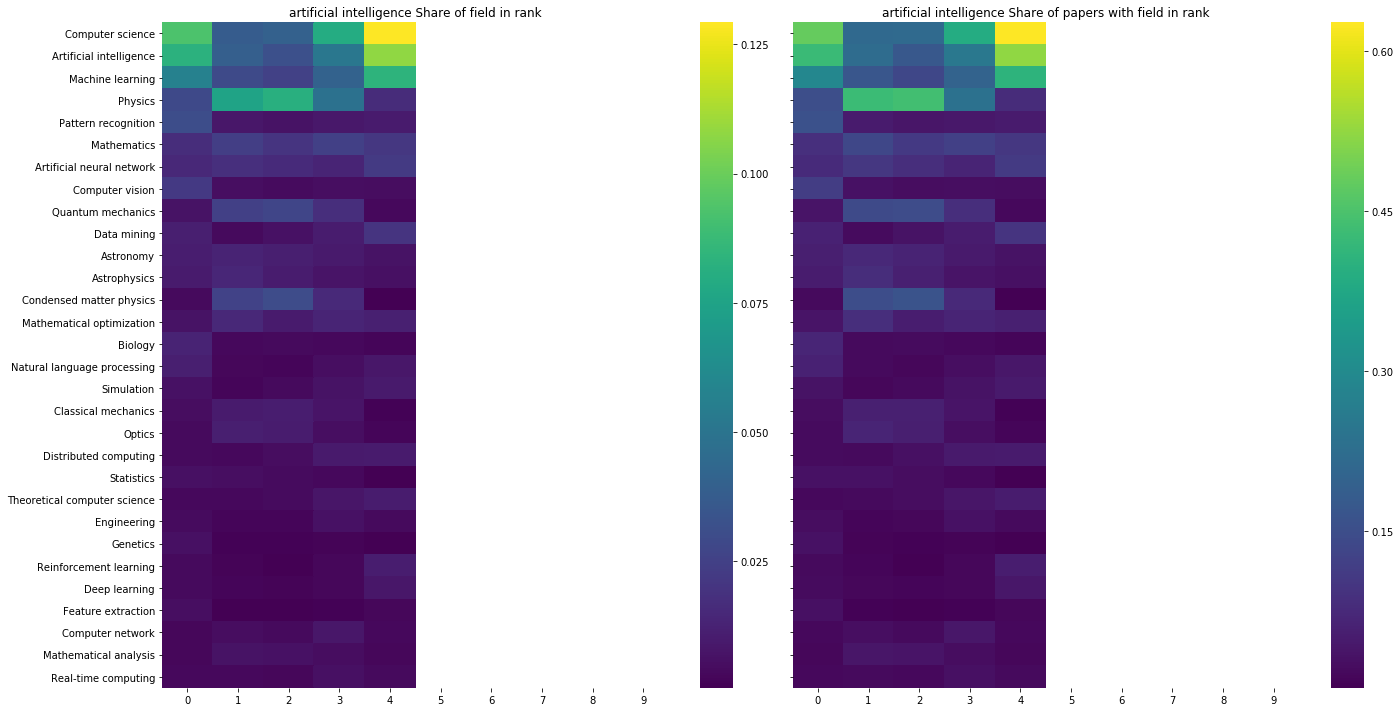

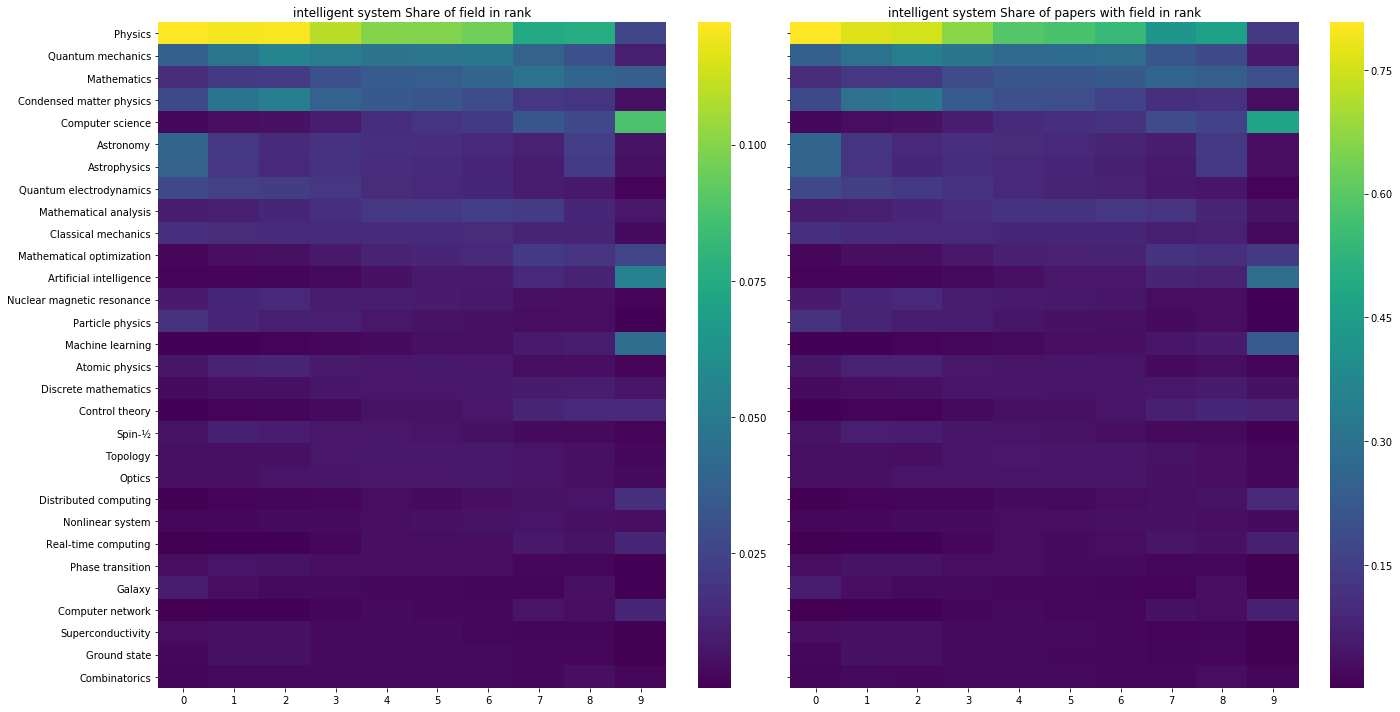

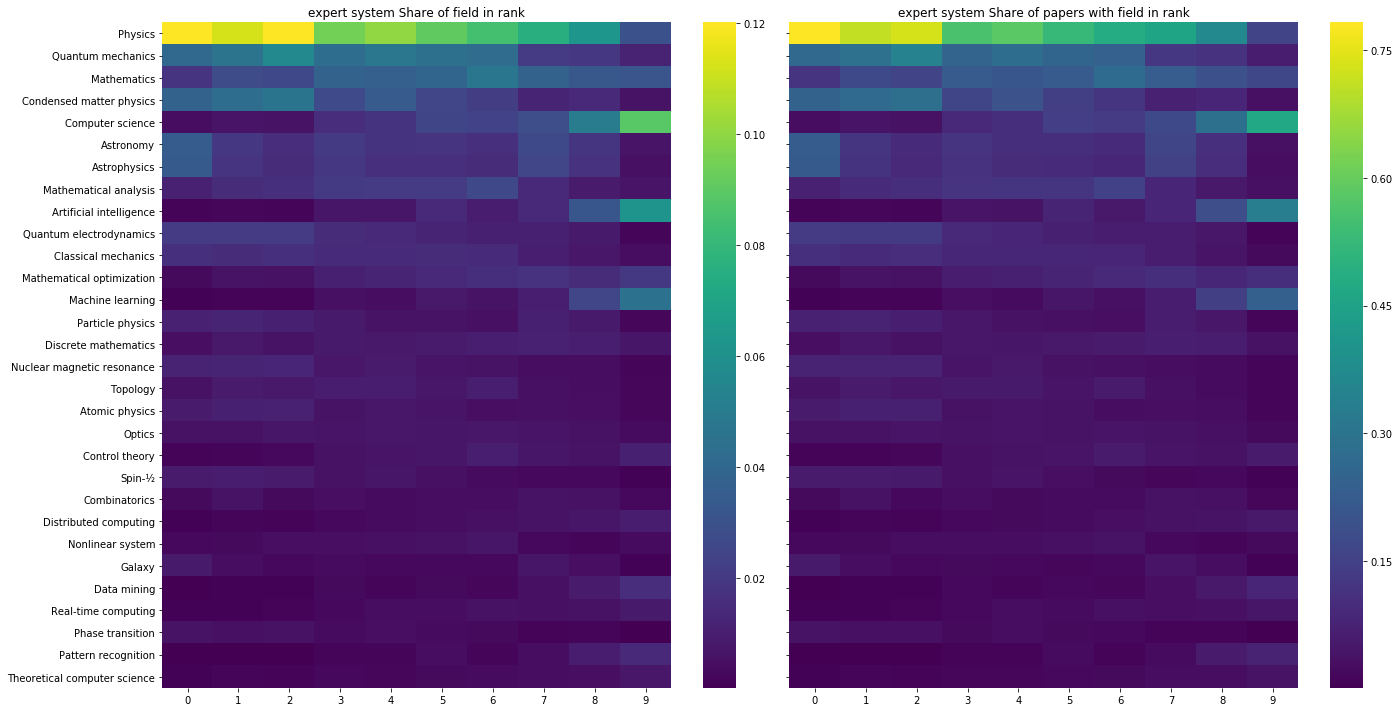

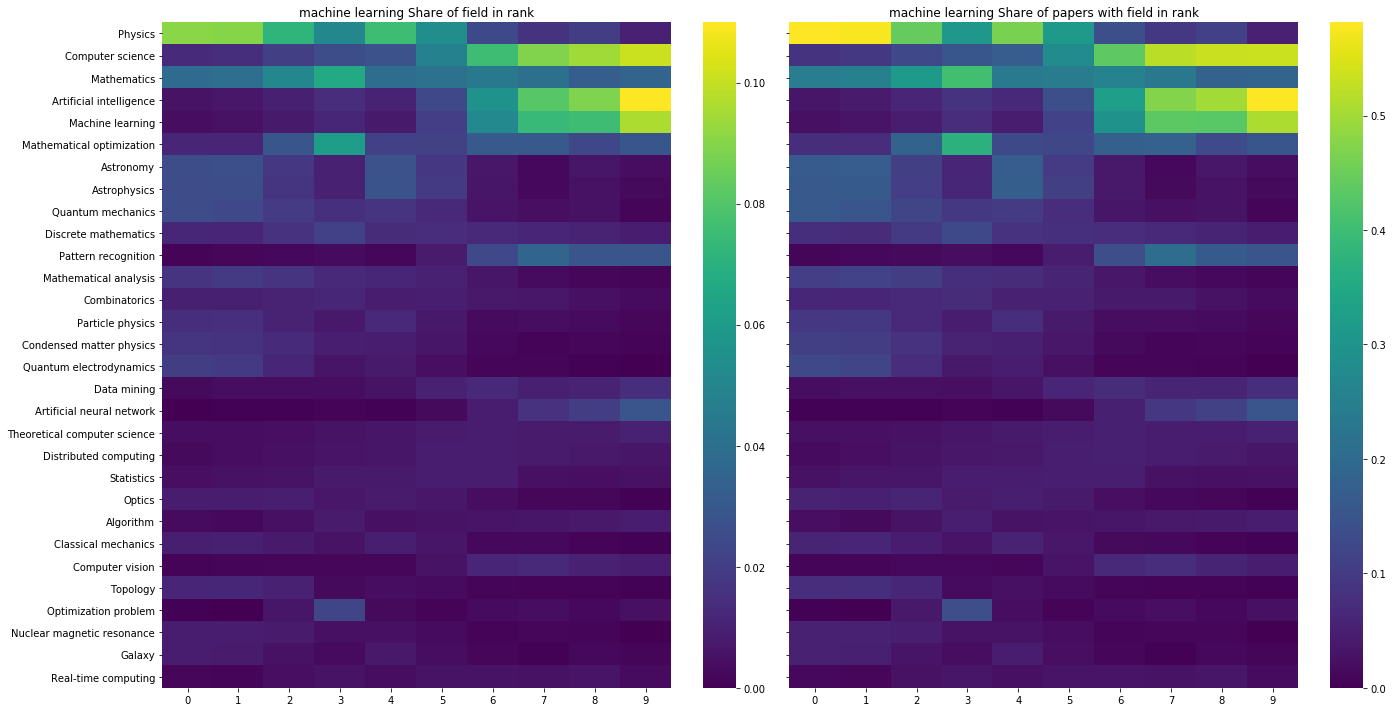

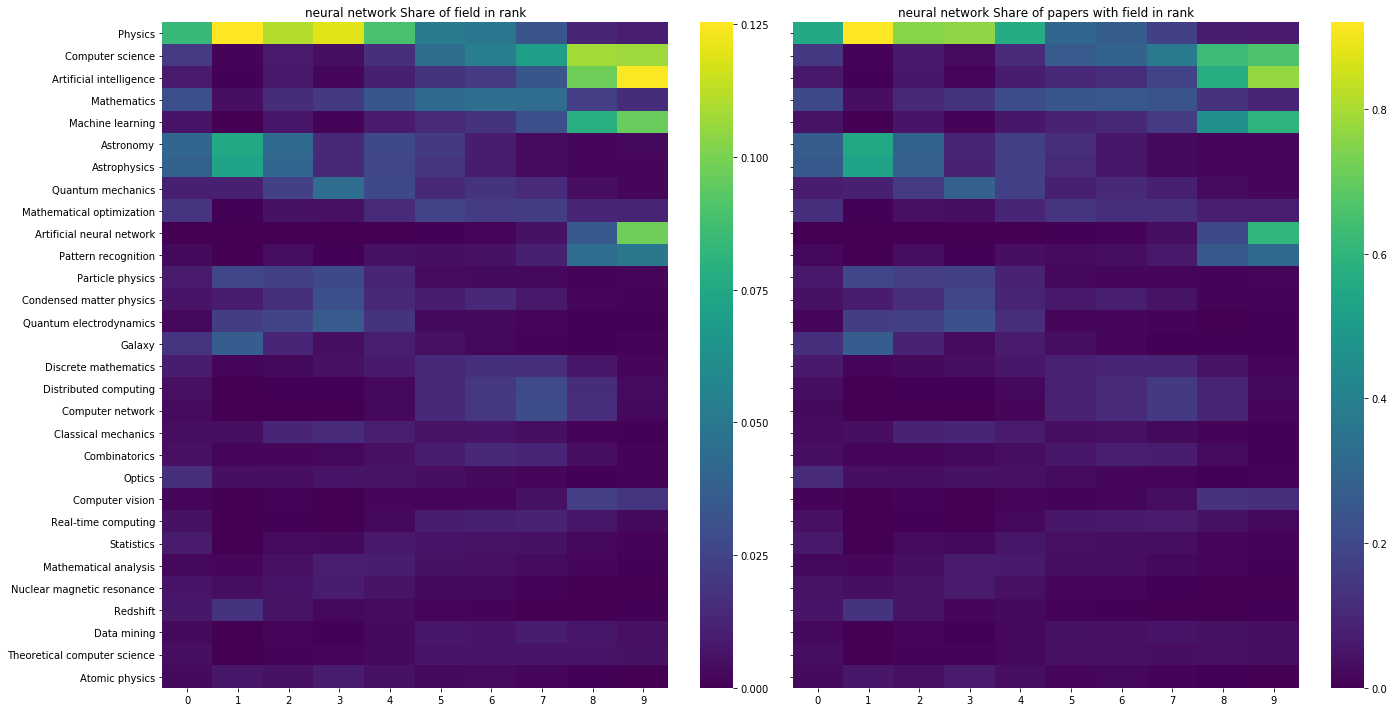

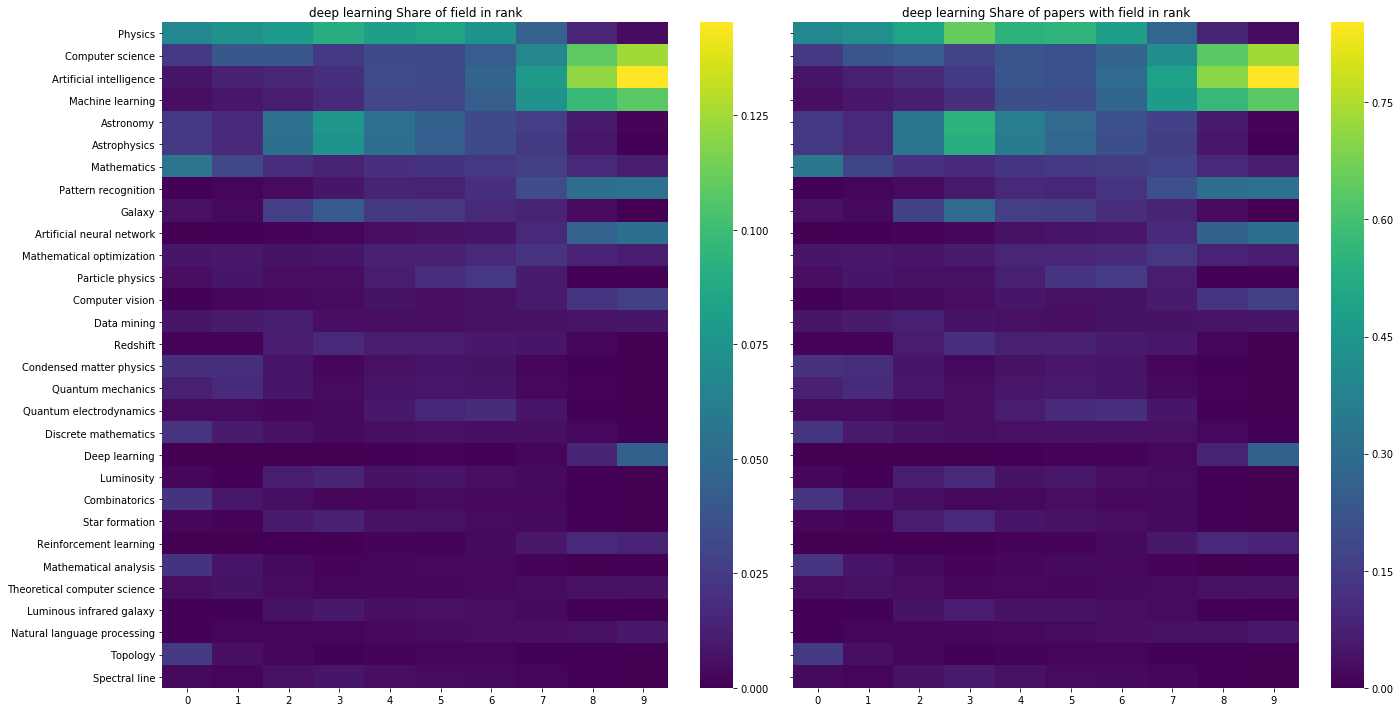

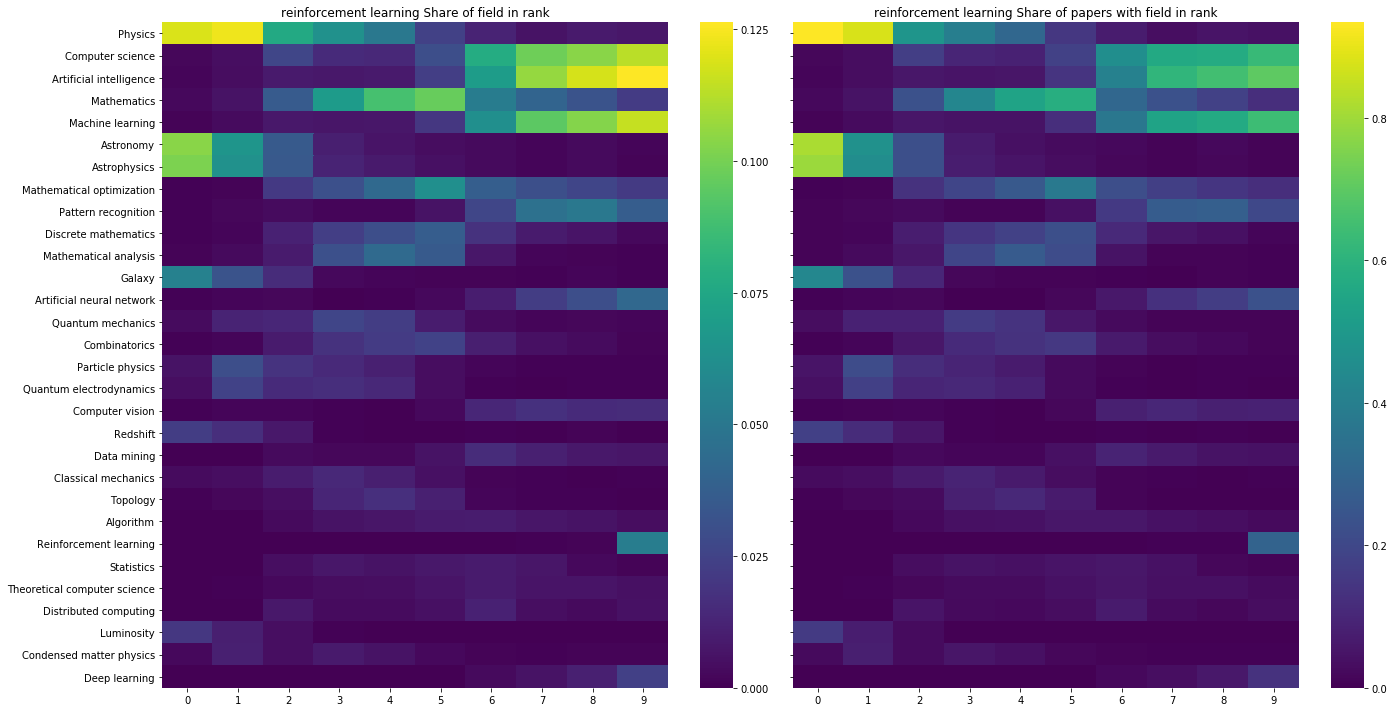

In [320]:
for x in queries:
    
    check_field_freqs(ai_bench_tests.loc[ai_bench_tests['query_source']==x].drop_duplicates('record_id'),
                      'query_relevance_rank',top_fields=30,name=x)

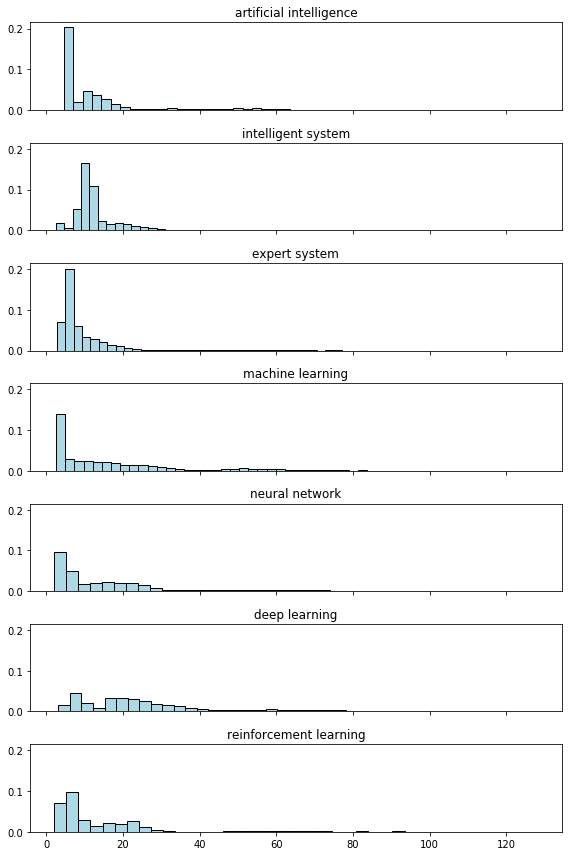

In [398]:
fig,ax = plt.subplots(figsize=(8,12),nrows=len(queries),sharex=True,sharey=True)

for n,x in enumerate(queries):
    
    ax[n].hist(ai_bench_tests.loc[ai_bench_tests['query_source']==x].drop_duplicates(
        'record_id')['relevance_score'],density=True,bins=40,facecolor='lightblue',edgecolor='black')
    
    ax[n].set_title(x)
    
plt.tight_layout()  

In [ ]:
#Plot historgram

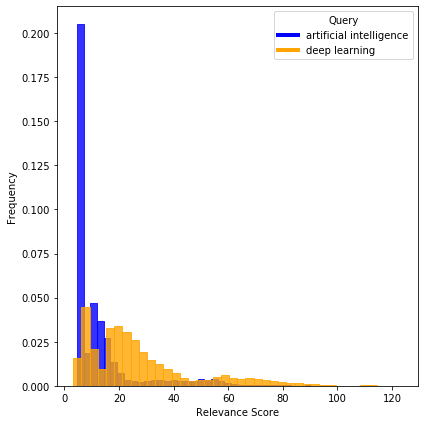

In [429]:
fig,ax = plt.subplots(figsize=(6,6))

f=['blue','orange']
q = ['artificial intelligence','deep learning']

for n,x in enumerate(q):
    
    ax.hist(ai_bench_tests.loc[ai_bench_tests['query_source']==x].drop_duplicates(
        'record_id')['relevance_score'],density=True,bins=40,facecolor=f[n],alpha=0.8,edgecolor=f[n])
    
    ax.set_xlabel('Relevance Score')
    ax.set_ylabel('Frequency')

legend_elements = [Line2D([0],[0],color=c,label=l,linewidth=4) for c,l in zip(f,q)]

ax.legend(handles = legend_elements,title='Query')

plt.tight_layout()

plt.savefig('../../figures/hist.pdf')

In [322]:
#We create lookup thresholds based on the above
threshold_lookup = {'artificial intelligence':4,
                   'intelligent system':9,'expert system':9,
                   'machine learning':6,'neural network':8,
                   'deep learning':7,'reinforcement learning':6}

In [328]:
ai_bench_tests['is_core'] = [x['query_relevance_rank']>=threshold_lookup[x['query_source']] for rid,x in 
                            ai_bench_tests.iterrows()]

In [865]:
multies = set([x for x in flatten(ai_bench_tests['institutions'],freq=True).index if '(' in x])

In [866]:
ai_bench_tests['has_multi_2'] = [has_multinationals(x,multies) for x in ai_bench_tests['institutions']]

In [1144]:
ai_unique_papers = ai_bench_tests.loc[(ai_bench_tests['has_multi_2']==False)
                                     &(ai_bench_tests['is_core']==True)].drop_duplicates('record_id').drop([
    'query_relevance_rank','query_source'],axis=1)

In [1147]:
len(topic_df)

45086

In [1146]:
year_freqs = ai_unique_papers['year'].value_counts().loc[
    np.arange(2000,2019)][::-1]

(year_freqs/year_freqs.sum()).cumsum()[:8]

2018    0.150764
2017    0.313403
2016    0.480073
2015    0.603079
2014    0.692926
2013    0.763323
2012    0.821600
2011    0.857789
Name: year, dtype: float64

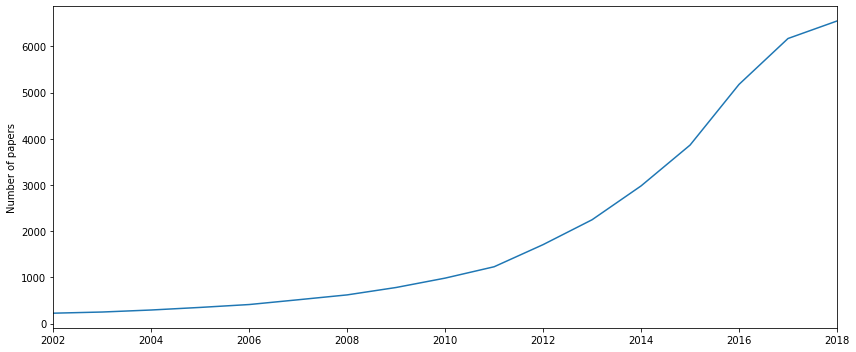

In [1135]:
ax = ai_unique_papers['year'].value_counts().loc[
    np.arange(2000,2019)].rolling(window=3).mean().dropna().plot(figsize=(12,5))

ax.set_ylabel('Number of papers')

plt.tight_layout()


plt.savefig('../../figures/trend.pdf')

In [1136]:
ai_unique_papers.to_csv('../../data/ai_unique_papers_2.csv',compression='zip')

## Topic modelling of research data


In [1137]:
def get_tokenised_abstracts(result_list):
    '''
    Returns a dict with abstract ids and token lists
    
    '''
    
    out = [(x['_id'],x['terms_tokens_entity']) for x in result_list]
    
    return(out)

In [1138]:
#We extract tokens from the initial AI results, and focus on the unique paper IDS

In [878]:
corpus_tokenised = pd.DataFrame(flatten([get_tokenised_abstracts(result) for result in ai_results]),
                               columns=['record_id','tokens'])

unique_paper_ids = set(ai_unique_papers['record_id'])

corpus_tokenised_selected = corpus_tokenised.loc[
    [x in unique_paper_ids for x in corpus_tokenised['record_id']]].drop_duplicates('record_id')

In [879]:
# Processing using the LDA pipeline above

In [880]:
c_big = CleanTokenize(corpus_tokenised_selected['tokens'])
c_big.tokenised = list(corpus_tokenised_selected['tokens'])
c_big.bigram(threshold=20)

In [881]:
# Topic modelling

In [882]:
ld = LdaPipeline(c_big.tokenised)
ld.filter_tokens().process().fit_lda(num_topics=200).predict_topics()

In [1129]:
topic_df = ld.predicted_df.copy()
topic_df.index = corpus_tokenised_selected.record_id
topic_df.to_csv('../../data/topic_mixes.df')

In [1151]:
pd.DataFrame(ld.lda_topics).to_csv('../../data/lda_topics.csv',index=False)